In [86]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import ElementsEnv

%erun Elements 5.12.0

os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/auxdir/'

sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/python/')

%load_ext autoreload
%autoreload 2

from nnpz.photometry import DirectoryFilterProvider, FnuuJyPrePostProcessor, PhotometryCalculator, PhotometryWithCorrectionsCalculator, GalacticReddeningPrePostProcessor
from nnpz.reference_sample.ReferenceSample import ReferenceSample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ref = ReferenceSample('/home/aalvarez/Work/Data/SC8/PHZ_Prod_04oct21/ProductionInputEcdmHandler/reference_sample_dir.dir/')

INFO    : Found provider PdzProvider
2021-10-12T11:42:13CEST ReferenceSample  INFO : Found provider PdzProvider
INFO    : Found provider SedProvider
2021-10-12T11:42:13CEST ReferenceSample  INFO : Found provider SedProvider


In [4]:
filters_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/SC8/PHZ_Calibration_28jan21/PhosphorosRootEcdmHandler/Phosphoros/AuxiliaryData/Filters/')

In [5]:
filter_map = {}
filter_names = filters_provider.getFilterNames()
for filter_name in filter_names:
    filter_map[filter_name] = filters_provider.getFilterTransmission(filter_name)

In [15]:
sed = ref.getSedData(611231)

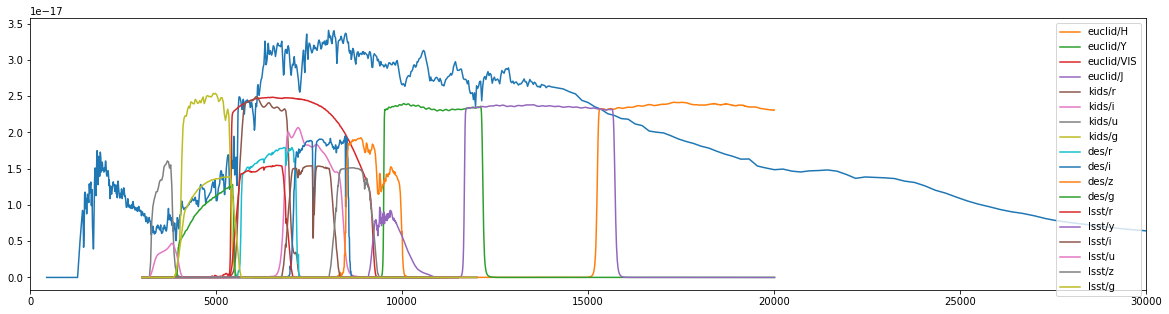

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(sed[:,0], sed[:,1])
msed = sed[:,1].max()
for fname, ftrans in filter_map.items():
    plt.plot(ftrans[:,0], ftrans[:,1]*msed, label=fname)
plt.xlim(0, 30000)
plt.legend()

In [73]:
prepost = FnuuJyPrePostProcessor(filter_map)
shifts = np.concatenate([np.arange(-100, 0), np.arange(1, 101)])
extra_shifts = np.concatenate([np.arange(-200, -100), np.arange(100, 201)])

In [74]:
calculator = PhotometryCalculator(filter_map, prepost, shifts)
extrapolate = PhotometryCalculator(filter_map, prepost, extra_shifts)
corrected_calculator = PhotometryWithCorrectionsCalculator(filter_map, prepost, 0.3, shifts)

In [75]:
_, raw = calculator.compute(sed)
_, extrapolated = extrapolate.compute(sed)
photo, ebv_corr, shift_corr= corrected_calculator.compute(sed)

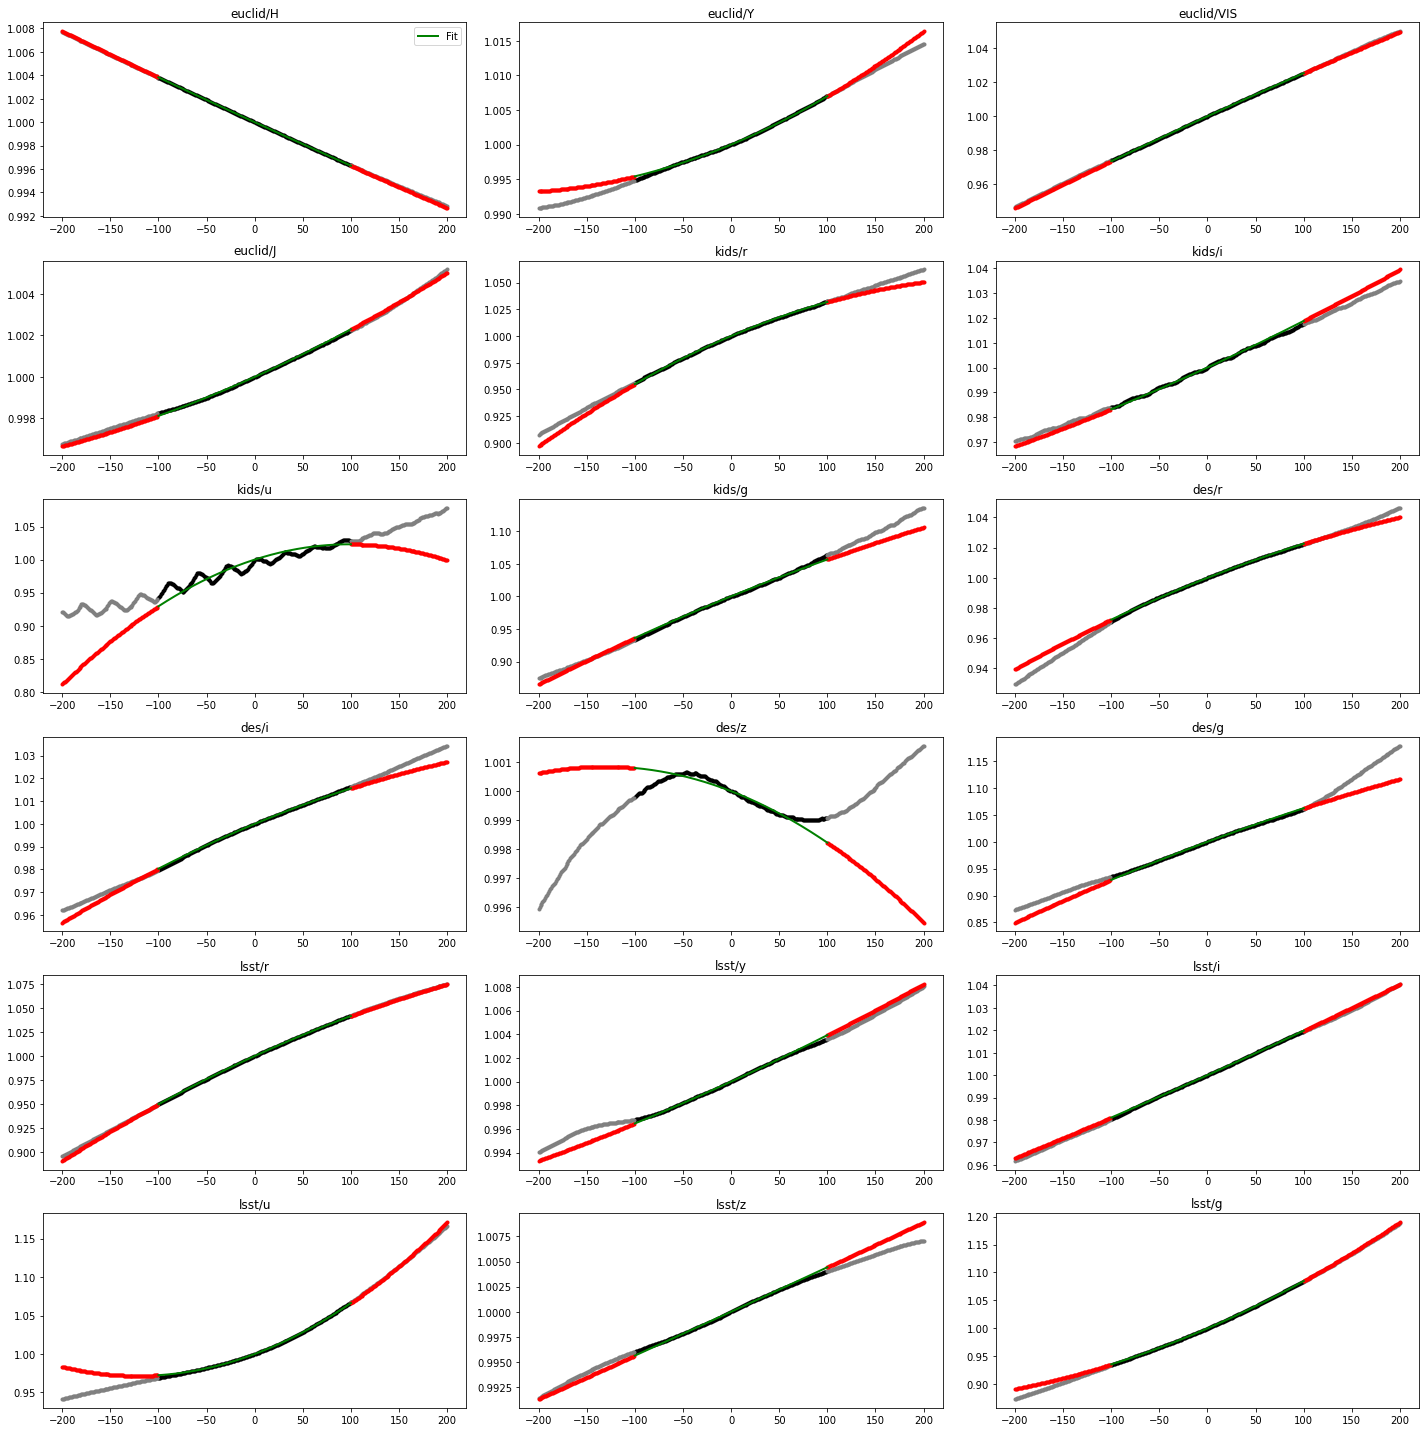

In [76]:
fig, axes = plt.subplots(ncols=3, nrows=len(filter_map)//3, figsize=(20, 20))

for i, ax in enumerate(axes.ravel()):
    fname = filter_names[i]
    
    ax.set_title(fname)
    ax.scatter(shifts, raw[fname] / photo[fname][0], marker='.', color='black')
    ax.scatter(extra_shifts, extrapolated[fname] / photo[fname][0], marker='.', color='gray')
    a, b = shift_corr[filter_names[i]]
    ax.scatter(extra_shifts, a * extra_shifts**2 + b * extra_shifts + 1, color='red', marker='.')
    ax.plot(shifts, a * shifts**2 + b * shifts + 1, color='green', linestyle='-', linewidth=2, label='Fit')
    
    if i == 0:
        ax.legend()
    
plt.tight_layout()

In [111]:
ebvs = np.linspace(0.0, 0.3, 20)
with_ebvs = np.zeros(len(ebvs), dtype=photo.dtype)
for i, e in enumerate(ebvs):
    reddener = GalacticReddeningPrePostProcessor(prepost, e)
    ebv_calc = PhotometryCalculator(filter_map, reddener)
    with_ebvs[i] = ebv_calc(sed)[0]

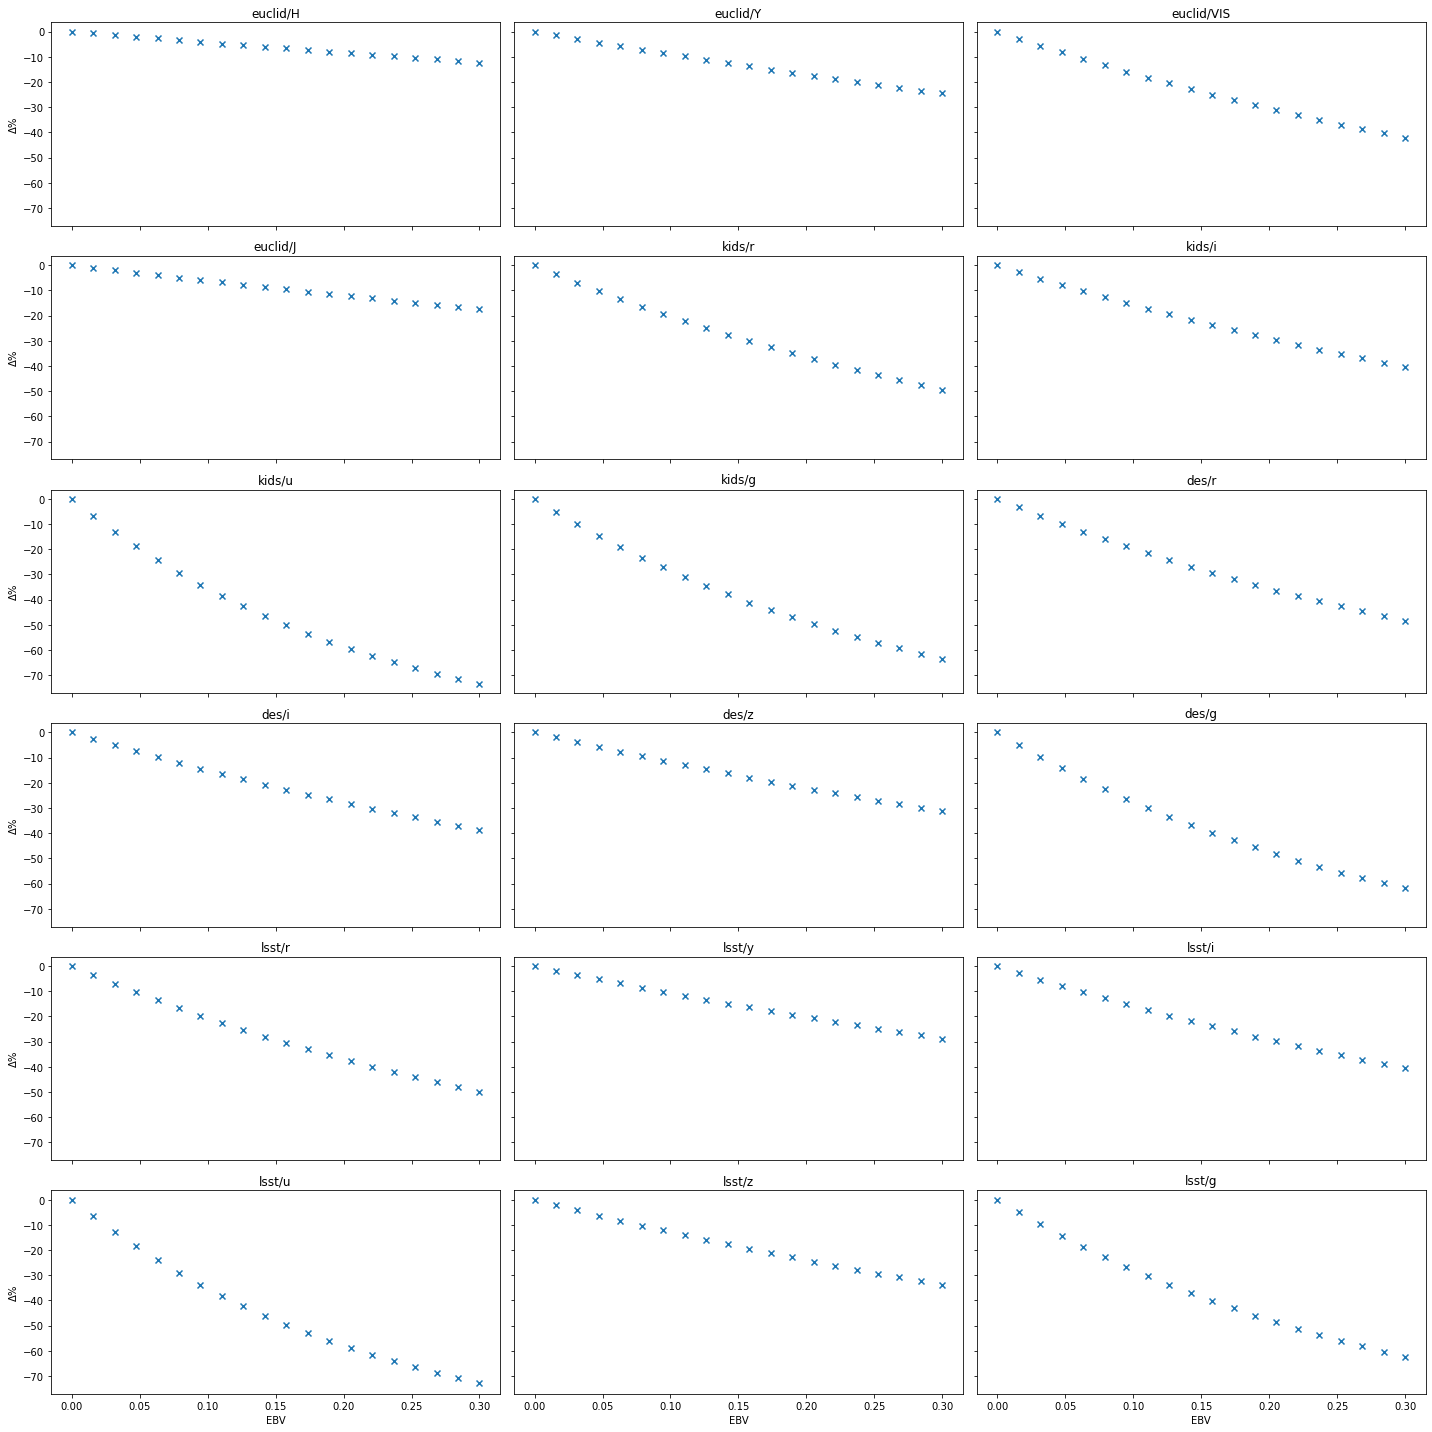

In [125]:
fig, axes = plt.subplots(ncols=3, nrows=len(filter_map)//3, figsize=(20, 20), sharex=True, sharey=True)

for i, ax in enumerate(axes.ravel()):
    fname = filter_names[i]
    
    a = ebv_corr[filter_names[i]]
    fx = photo[fname][0]
    
    ax.set_title(fname)
    #ax.scatter(ebvs, with_ebvs[fname], marker='o', label='Direct')
    approx = fx * 10 ** (-0.4 *  a * ebvs) 
    ax.scatter(ebvs, 100* (approx - photo[fname][0])/ photo[fname][0], marker='x')
    
    if i >= 15:
        ax.set_xlabel('EBV')
    if i % 3 == 0:
        ax.set_ylabel('$\Delta$%')
    
plt.tight_layout()